# 1.2 Binary Question Classification

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from enum import Enum

from models.answer_exists_models import *

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
class Annotation_error(Enum):
    UNANSWERED = -1
    BAD_TOKENIZATION_OR_DATA = -2
    IGNORED = -3

Load pre-processed data from memory.

In [4]:
path_train_set = "data/train_set_stanza.pkl"
path_validation_set = "data/validation_set_stanza.pkl"

In [5]:
train_set = pd.read_pickle(path_train_set)
validation_set = pd.read_pickle(path_validation_set)

In [6]:
train_en = train_set[train_set["language"] == "english"]
train_fi = train_set[train_set["language"] == "finnish"]
train_ja = train_set[train_set["language"] == "japanese"]

In [7]:
validation_en = validation_set[validation_set["language"] == "english"]
validation_fi = validation_set[validation_set["language"] == "finnish"]
validation_ja = validation_set[validation_set["language"] == "japanese"]

In [35]:
def words_to_ids(word_lists):
    word_to_ix = {}
    for words in word_lists:
        for word in words:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
    return word_to_ix

Functions to create new features

In [36]:
def make_bow_vector(sentence, word_to_ix):
    vec = np.zeros(len(word_to_ix))
    for word in sentence:
        vec[word_to_ix[word]] += 1
    return vec

In [37]:
def get_bag_of_words(data_feature, word_ids):
    X = np.empty((len(data_feature), len(word_ids)))
    for i, _ in enumerate(data_feature):
        X[i] = make_bow_vector(data_feature.iloc[i], word_ids)
    return X

In [38]:
def get_lengths(data_feature):
    return np.array([len(words) for words in data_feature])

In [39]:
def count_word_overlaps(data_feature, reference_data_feature, normalize:bool = True):
    assert(data_feature.shape[0] == reference_data_feature.shape[0])
    
    X = np.empty(data_feature.shape[0])
    for i in range(data_feature.shape[0]):
        word_ids = words_to_ids([reference_data_feature.iloc[i]])
        X[i] = np.sum([token in word_ids for token in data_feature.iloc[i]]) # @TODO: skip first word and last word?
        
        if normalize:
            size = len(data_feature.iloc[i])
            X[i] /= size
        
    return X

In [40]:
count_word_overlaps(train_en['question'], train_en['document'])

array([0.42857143, 0.7       , 0.57142857, ..., 0.45454545, 0.28571429,
       0.33333333])

## Feature Exploration
### Distributions over the number of words

In [13]:
def plot_document_length_dist(dataset, title):
    lengths = get_lengths(dataset['document'])

    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Number of tokens")

    ax.hist(lengths, bins=300, density=True) # let's use an histogram instead with fixed bins, since their is much variability.
    
    #ticks = np.linspace(min(uniques), max(uniques)+1, 10)
    #ax.set_xticks(ticks)

In [14]:
def plot_question_length_dist(dataset, title):
    question_lengths = get_lengths(dataset['question'])

    uniques, uniques_counts = np.unique(question_lengths, return_counts=True)
    index_sorted = np.argsort(uniques, axis=None)

    uniques_counts_percentage = uniques_counts / np.sum(uniques_counts) * 100

    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Number of tokens")

    x = uniques[index_sorted]
    ax.bar(x, uniques_counts_percentage[index_sorted])
    ticks = np.arange(min(uniques), max(uniques)+1, 1)
    ax.set_xticks(ticks)

#### English

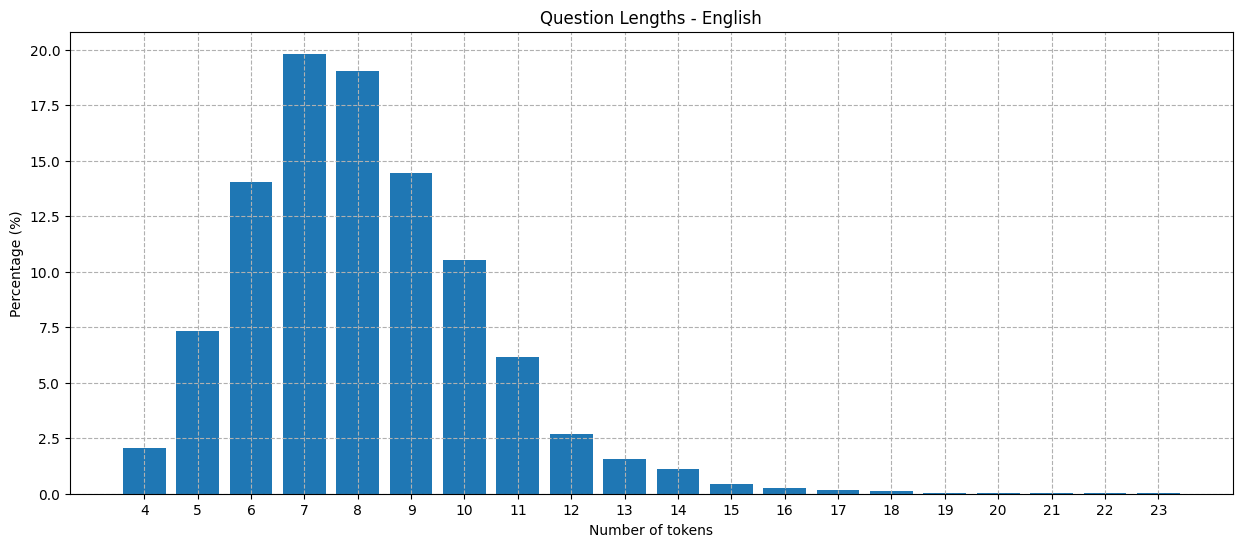

In [237]:
plot_question_length_dist(train_en, "Question Lengths - English")

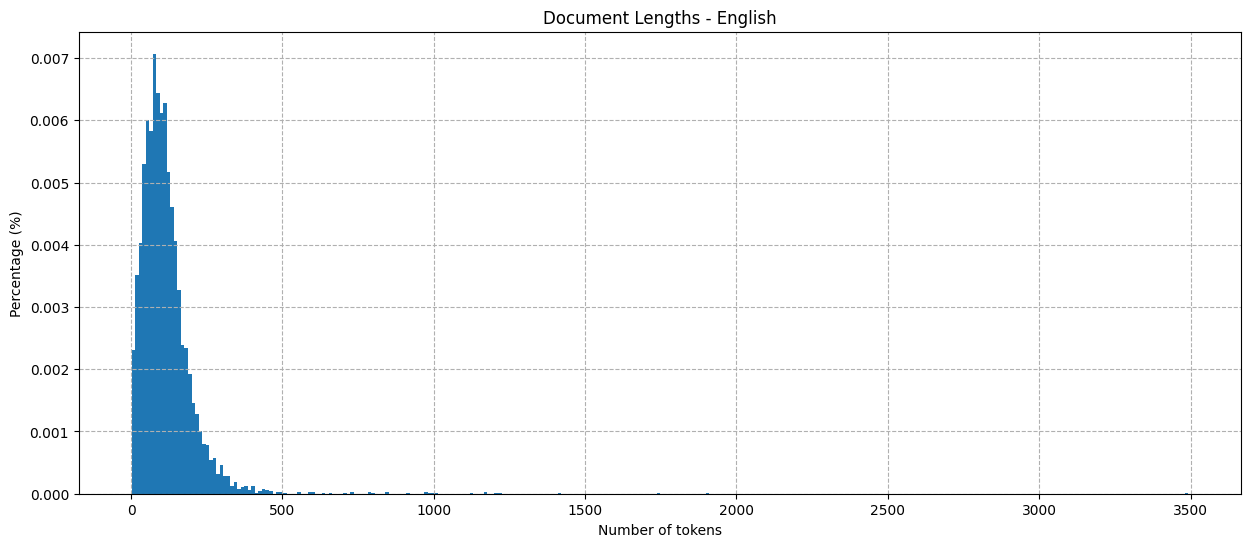

In [238]:
plot_document_length_dist(train_en, "Document Lengths - English")

#### Finnish

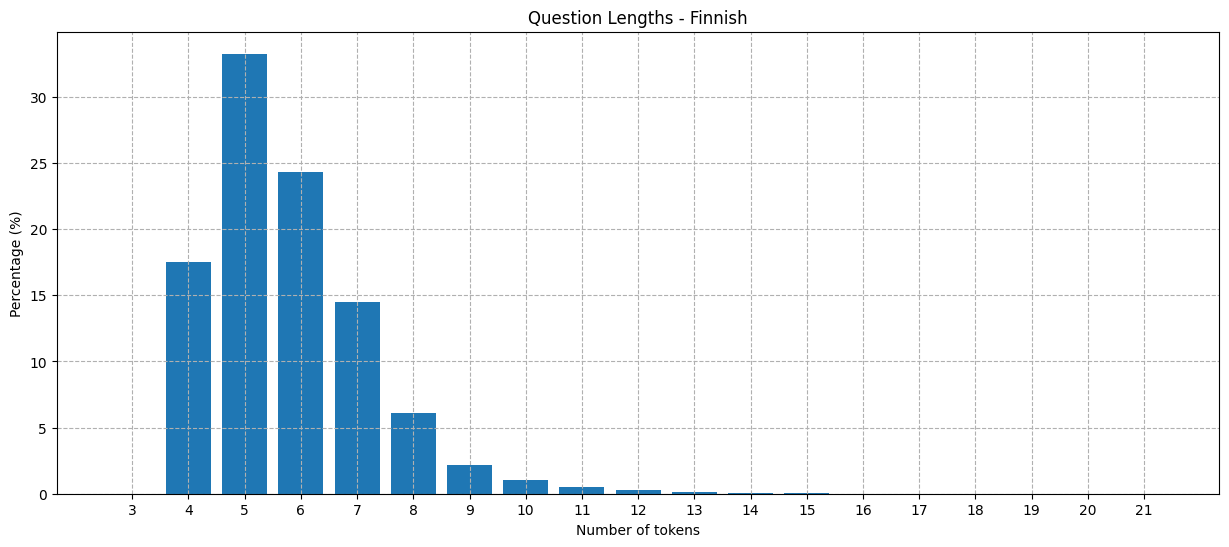

In [239]:
plot_question_length_dist(train_fi, "Question Lengths - Finnish")

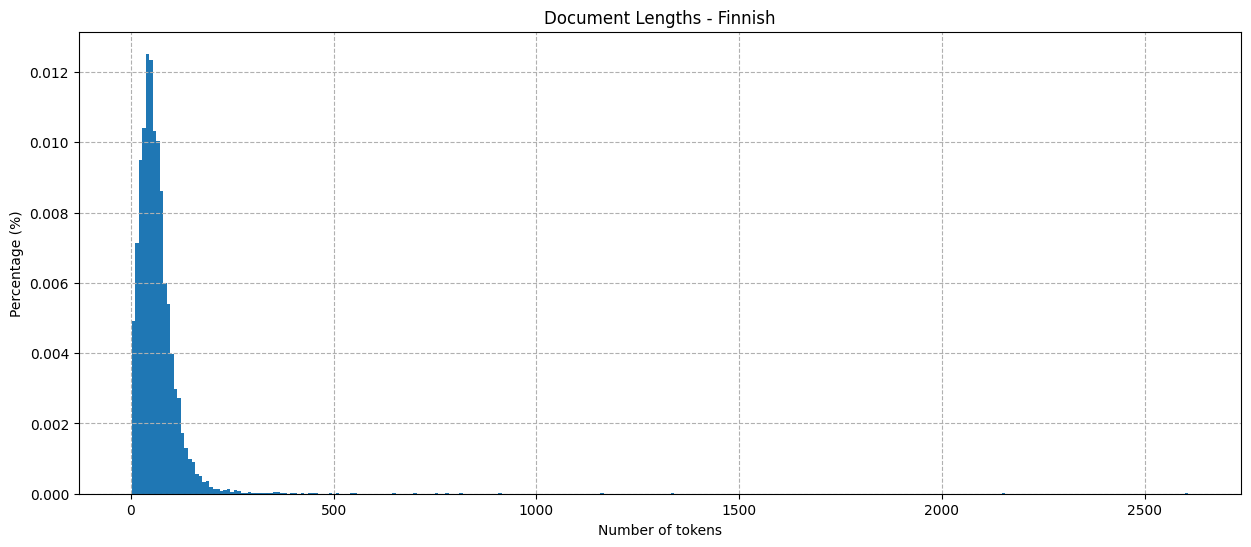

In [240]:
plot_document_length_dist(train_fi, "Document Lengths - Finnish")

#### Japenese

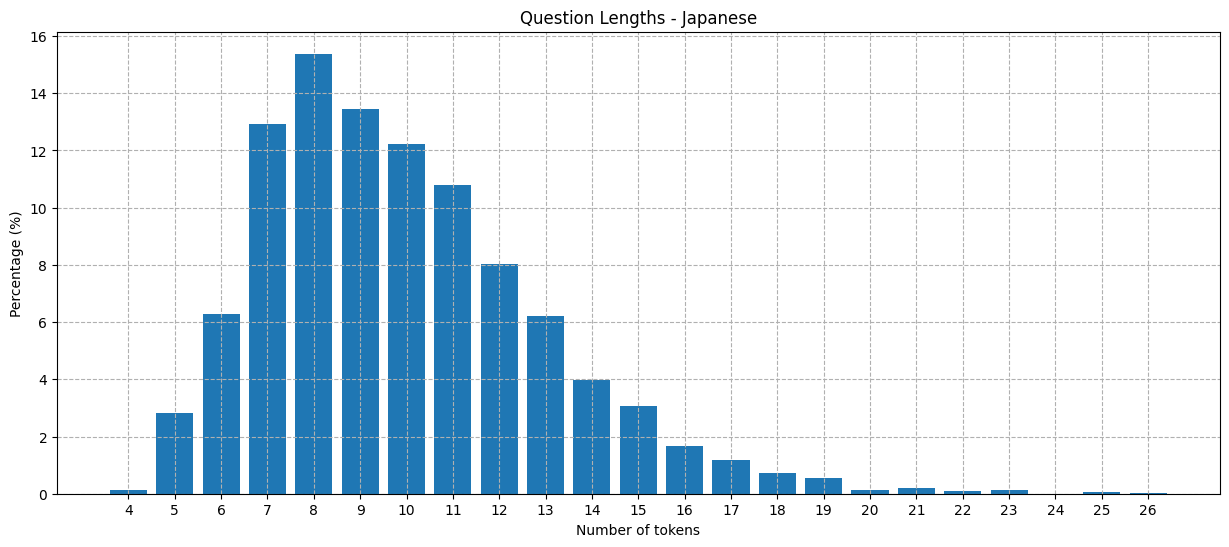

In [241]:
plot_question_length_dist(train_jp, "Question Lengths - Japanese")

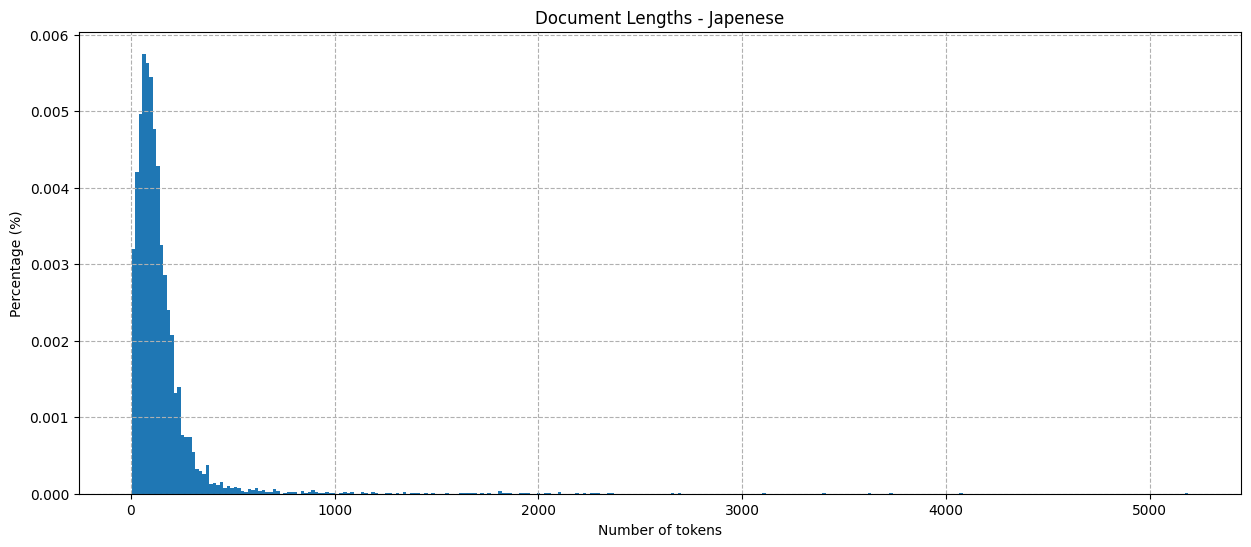

In [242]:
plot_document_length_dist(train_jp, "Document Lengths - Japenese")

### Features 

@ASK: should the model be simple, such that we can interprete the weights (+ features effect)?

#### Reason
OK:
- Bag of Words for Question tokens (some words are easier to answer, e.g. When vs How)
- Number of tokens in document (A longer document is more likely to have the correct answer than a short document)
- Number of tokens in question (A longer answer looks for a very specific answer)
- (Proposed in project description) Answer overlap between document and text
-----------------
Ignored:
- Bag of Words for Document tokens (probably doesn't make sense)



--------------------
#### Memory getting exhausted

In [245]:
# @Note: Too slow. This corresponds to the overlap between the two features and taking into account which words overlap
# A simpler version is to give a single numeric value for the fractions of words overlapping.
def get_bag_of_words_overlaps(data_feature_1, data_feature_2, word_ids):
    bow_1 = get_bag_of_words(data_feature_1, word_ids)
    bow_2 = get_bag_of_words(data_feature_2, word_ids)
    return bow_1 * bow_2

In [21]:
word_ids_all = words_to_ids(pd.concat([train_en['question'], train_en['document'], validation_en['question'], validation_en['document']]))
print("{} unique words".format(len(word_ids_all)))

#get_bag_of_words_overlaps(train_en['question'], train_en['document'], word_ids_all)

65254 unique words


-----------------------


## Q1.2a

In [41]:
def get_X(dataset, word_ids):
    bow = get_bag_of_words(dataset['question'], word_ids)
    document_lengths = get_lengths(dataset['document']).reshape((-1,1))
    question_lengths = get_lengths(dataset['question']).reshape((-1,1))
    word_overlap = count_word_overlaps(dataset['question'], dataset['document']).reshape((-1,1))
    X = np.concatenate((bow, document_lengths, question_lengths, word_overlap), axis=1)
    return X

In [42]:
# If the question is answered, then predict "1". Otherwise predict "0".
def get_target(data):
    answer_set = data['document_answer_region']
    y = np.empty(answer_set.shape[0])

    for i, answer in enumerate(answer_set):
        if type(answer) == Annotation_error and answer == Annotation_error.UNANSWERED: # @TODO: if we don't do the annotation stuff, then we can check for -1 here
            y[i] = 0
        else:
            y[i] = 1
    return y

In [43]:
def str_target_summary(y):
    num_answered = np.sum(y == 1)
    num_unanswered = np.sum(y == 0)
    return "Questions answered: {}, unanswered: {}.".format(num_answered, num_unanswered)

## Q1.2b+c

In [59]:
def evaluate(y_pred, y_true):
    report = classification_report(y_true, y_pred)
    print(report)
    
    cm = confusion_matrix(y_true, y_pred) / len(y_pred) # normalize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

In [60]:
# @TODO: move?
def print_logistic_regression_weights(lr_model, word_ids):
    intercept = lr_model.classifier.intercept_
    weights = lr_model.classifier.coef_[0]

    print("W_when={}".format(weights[word_ids["When"]]))
    print("W_overlap={}".format(weights[-1]))    

In [62]:
def do(train, validation):
    word_ids = words_to_ids(pd.concat([train['question'], validation['question']]))
    print("{} unique words".format(len(word_ids)))
    
    X_train = get_X(train, word_ids)
    y_train = get_target(train)

    X_validation = get_X(validation, word_ids)
    y_validation = get_target(validation)

    print("train: " + str_target_summary(y_train))
    print("validation: " + str_target_summary(y_validation))

    model = Logistic_regression()
    model.train(X_train, y_train)
    #print_logistic_regression_weights(model, word_ids)
    
    preds = model.predict(X_validation)
    
    evaluate(preds, y_validation)
    
    #return preds, y_validation
    

## English

Let's do prediction on the validation set for each language and compute the accuracy.

5527 unique words
train: Questions answered: 3696, unanswered: 3693.
validation: Questions answered: 495, unanswered: 495.
W_when=-0.29035350898839973
W_overlap=8.931925949572666
              precision    recall  f1-score   support

         0.0       0.75      0.68      0.71       495
         1.0       0.71      0.77      0.74       495

    accuracy                           0.72       990
   macro avg       0.73      0.72      0.72       990
weighted avg       0.73      0.72      0.72       990



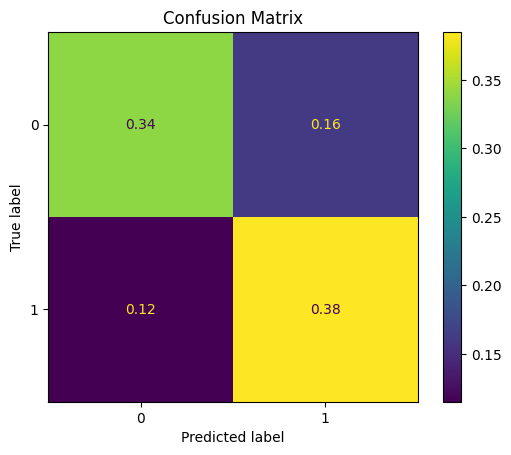

In [55]:
do(train_en, validation_en) 

## Finnish

10832 unique words
train: Questions answered: 6855, unanswered: 6846.
validation: Questions answered: 843, unanswered: 843.
              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       843
         1.0       0.76      0.72      0.74       843

    accuracy                           0.74      1686
   macro avg       0.74      0.74      0.74      1686
weighted avg       0.74      0.74      0.74      1686



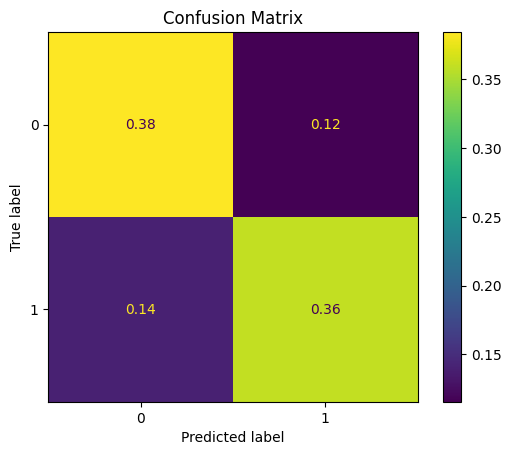

In [63]:
do(train_fi, validation_fi)

## Japanese

6650 unique words
train: Questions answered: 4389, unanswered: 4389.
validation: Questions answered: 518, unanswered: 518.
              precision    recall  f1-score   support

         0.0       0.70      0.63      0.66       518
         1.0       0.66      0.73      0.69       518

    accuracy                           0.68      1036
   macro avg       0.68      0.68      0.68      1036
weighted avg       0.68      0.68      0.68      1036



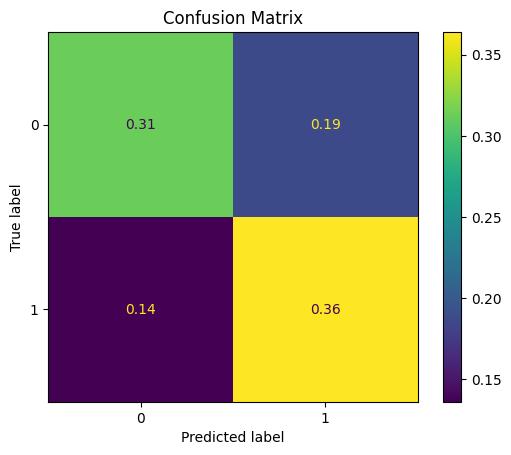

In [64]:
do(train_ja, validation_ja)

In [196]:
train_en

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(26, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(12, 13)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(27, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(16, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(1, 37)"
...,...,...,...,...,...
7384,english,"[What, was, Neil, Brooks, ', fastest, recorded...","[Swimming, at, the, 1980, Summer, Olympics, –,...","[The, medley, relay, was, scheduled, in, the, ...",Annotation_error.UNANSWERED
7385,english,"[Who, are, the, three, most, important, easter...","[Eastern, philosophy]","[Sāmkhya, is, a, dualist, philosophical, tradi...",Annotation_error.UNANSWERED
7386,english,"[Who, was, costume, designer, for, the, first,...","[John, Mollo]","[Mollo, was, surprised, by, the, success, of, ...",Annotation_error.UNANSWERED
7387,english,"[Who, developed, the, first, thermonuclear, we...","[History, of, nuclear, weapons]","[In, the, end, ,, President, Truman, made, the...",Annotation_error.UNANSWERED
